<span style='color:gray'> <span style="font-size:25px;"> **Development of "Machine Learning Models"  (Workflow)**
    
In this Notebook, the machine learning model will be created and then the data from well-logs DLIS file [after preprocessing, sorting and finalizing the data] is loaded as input for Machine Learning model (ML); 
* Random Forest Regressor
* Gradient Boosting Regressor
    
    
For the prediction of petrophysical properties, such as porosity, permeability and water saturation, these two Regressor models **Random Forest Regressor** and **Gradient Boosting Regressor** are suitable.

They are Ensemble Based Tree Methods; they are based on the generation of Decision Trees.

We use Regression Models since we want to predict a continuous variable.

**Advantages** of the 2 regression models, since they are based on Decision Trees:

* They do not need the normalization or scaling of the original dataset;
* They are not sensitive to outliers, thus, outliers detection and removal are not required.

**==================================================================================================================**
    
In well-log machine learning models, the choice between regression and classification (Supervised ML) depends on the nature of the problem you are trying to solve and the type of data you have. Let's break down the reasons why regression is often preferred over classification in this context:

**Continuous Output**: Well-log data often involves continuous measurements such as porosity, permeability, resistivity, and other geological properties. Regression is well-suited for predicting and modeling continuous numerical values. Classification, on the other hand, is typically used when the output is categorical or discrete, like classifying lithology or rock types.

**Data Distribution**: Well-log data tends to have a wide range of continuous values. Using classification would require discretizing this data into bins or classes, which can lead to loss of information and potentially introduce biases. Regression models can capture the nuances and variations present in the continuous data more effectively.

**Evaluation Metrics**: Regression models are evaluated using metrics such as mean squared error (MSE), root mean squared error (RMSE), or mean absolute error (MAE). These metrics are well-suited for measuring the accuracy of predictions involving continuous values. Classification models, on the other hand, use metrics like accuracy, precision, recall, and F1-score, which are designed for categorical predictions.

**Feature Importance**: Well-log data analysis often involves understanding the relationships between different geological features and the target property. Regression models can provide insights into the quantitative impact of each feature on the predicted values, aiding in geological interpretation.


<span style='color:gray'> <span style="font-size:20px;"> 
**Importing Libraries, Regressors, and Required Dependencies**

In [1]:
%pip install --quiet --upgrade scikit-learn==1.2.2
%pip install --quiet qbstyles


# Importing the dependencies
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from qbstyles import mpl_style
mpl_style(dark=False)  # Set light matplotlib style

import matplotlib.patches as mpatches  # To create a legend with a color box
import pickle

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Importing the models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
                                         
from sklearn.model_selection import RandomizedSearchCV

# train_test_split is a function 
# cross_val_score and KFold are functions

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold 

# Regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, mean_absolute_error

# The package "Matplotlib Inline Back-end" provides support for Matplotlib to display figures directly inline
# "svg" stands for "scalable vector graphic". The plot can be scaled without compromising its quality
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

<span style='color:red'> <span style="font-size:20px;"> **3-BRSA-944A-RJS**:</span> </span>

<span style='color:blue'> <span style="font-size:15px;"> **Well-log data**:</span> </span>

In [2]:
#file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_944_ML.csv'
file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_944_ML_COM.csv'

df_944_ML =  pd.read_csv(file_path)
df_944_ML.rename(columns={'CMFF': 'NMRFF', 'CMRP_3MS': 'NMREFF', 'TCMR': 'NMRTOT'}, inplace=True)
df_944_ML.drop(columns = ['AT10', 'AT30'], inplace=True) # Replace with the actual column names you want to remove
df_944_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_944_ML

<span style='color:blue'> <span style="font-size:15px;"> **Trajectory data**:</span> </span>

In [3]:
def remove_lines_from_file(input_file, output_file, lines_to_remove):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Remove specified lines
    lines = [line for i, line in enumerate(lines, 1) if i not in lines_to_remove]

    with open(output_file, 'w') as file:
        file.writelines(lines)

# Specify the input file, output file, and line numbers to remove
input_file = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados Direcionais/3-brsa-944a-rjs_direcionais.txt'
output_file = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados Direcionais/output.txt'
lines_to_remove = list(range(0, 25))     # remove to line 

# Call the function to remove the specified lines
remove_lines_from_file(input_file, output_file, lines_to_remove)

#======================== loading new file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados Direcionais/output.txt'

# Read the file into a Pandas DataFrame using space as the delimiter
df = pd.read_csv(file_path, delim_whitespace=True)   
df = df.iloc[1:-1]    # Remove the and first last row

#======================== loading new file
df = df[['PROFUNDIDADE', 'PROFUNDIDADE.1', 'INCLINACAO', 'AZIMUTE']]
df = df.rename(columns={'PROFUNDIDADE': 'MD'})
df = df.rename(columns={'PROFUNDIDADE.1': 'TVD'})
df = df.rename(columns={'INCLINACAO': 'INC'})
df = df.rename(columns={'AZIMUTE': 'AZI'})
df.reset_index(drop=True, inplace=True)                       # Reset the index
#df

<span style='color:blue'> <span style="font-size:15px;"> **Petrophysics data**:</span> </span>

In [4]:
#pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)

# Replace 'your_file.xlsx' with the path to your Excel file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados de Rochas e Fluidos/PETROGRAFIA_BASICA/3BRSA944ARJSPetrofisica_2.xls'
df_Ptroph_944 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_944 = df_Ptroph_944[["Profundidade", "Permeab. Long. (mD)", "Porosidade %"]].sort_values("Profundidade", ascending=True).dropna()

columns_to_modify = ['Profundidade', 'Permeab. Long. (mD)', 'Porosidade %']  # Replace with your actual column names


# Replace commas with dots in the specified columns
for col in columns_to_modify:
    df_Ptroph_944[col] = df_Ptroph_944[col].astype(str).str.replace(',', '.')

#df_Ptroph = df_Ptroph.iloc[102:164]  # Extract rows A to B (inclusive)
df_Ptroph_944 = df_Ptroph_944.reset_index(drop=True)  # Reset the index after sorting


df_Ptroph_944 = df_Ptroph_944.rename(columns={'Profundidade': 'MD', 'Permeab. Long. (mD)': 'k', 'Porosidade %': 'phi'})


# Continue with your code
DEPTH_lab = df_Ptroph_944["MD"]
K_lab = df_Ptroph_944["k"]
PHI_lab = df_Ptroph_944["phi"]


# Applying a filter to remove rows with 'Permeab. Long. (mD)' lower than 1
df_Ptroph_944['k'] = pd.to_numeric(df_Ptroph_944['k'], errors='coerce')
df_Ptroph_944 = df_Ptroph_944[df_Ptroph_944['k'] >= 1]
df_Ptroph_944 = df_Ptroph_944[df_Ptroph_944['k'] <= 3000]


# Export the modified DataFrame to a new Excel file
output_file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados de Rochas e Fluidos/PETROGRAFIA_BASICA/Petrophysic_NEW_944.xlsx'
df_Ptroph_944.to_excel(output_file_path, index=False)

df_Ptroph_944

,MD,k,phi
9,5717.55,14.90,16.1
10,5717.6,28.60,15.9
16,5719.4,1.04,12.3
18,5719.65,64.00,18.9
19,5719.95,27.90,17.3
20,5720.25,19.10,14.0
21,5720.3,4.91,15.4
22,5720.55,39.60,18.2
25,5721.35,1.16,11.0
26,5721.65,3.42,9.4


In [5]:
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados de Rochas e Fluidos/PETROGRAFIA_BASICA/Petrophysic_NEW_944.xlsx'
df_Ptroph_944 = pd.read_excel(file_path)
#df_Ptroph_944

<span style='color:blue'> <span style="font-size:15px;"> **Build a well-log dataframe based on Petrophysical dataframe**:</span> </span>

In [6]:
depth_range = (df_Ptroph_944['MD'].min(), df_Ptroph_944['MD'].max())

initial_depth = float(str(depth_range[0]))
final_depth = float(str(depth_range[1]))

print("Initial Depth:", initial_depth)
print("Final Depth:", final_depth)

Initial Depth: 5717.55
Final Depth: 5795.75


Limit the well-log data [defining the upper and lower limit] for well-log data based on petrophyscial data

In [7]:
# Filter the DataFrame to include rows with 'MD' within the depth range
df_944_ML = df_944_ML[(df_944_ML['DEPTH'] >= depth_range[0]) & (df_944_ML['DEPTH'] <= depth_range[1])]
#df_944_ML

we filtered the well-log data corresponding to the DEPTH in Petrophysical data, 

In [8]:
import numpy as np
import pandas as pd

# Assuming df_Ptroph_944 and df_944_ML are already defined DataFrames

# Resetting indices to avoid index mismatch issues
df_Ptroph_944.reset_index(drop=True, inplace=True)
df_944_ML.reset_index(drop=True, inplace=True)

depth_values = df_Ptroph_944['MD'].values
depth_944_values = df_944_ML['DEPTH'].values

for i, depth in enumerate(depth_values):
    absolute_diff = np.abs(depth_944_values - depth)
    nearest_depth_index = np.argmin(absolute_diff)
    
    if absolute_diff[nearest_depth_index] < 0.05:
        df_Ptroph_944.at[i, 'Assigned_DEPTH'] = df_944_ML.at[nearest_depth_index, 'DEPTH']
    else:
        df_Ptroph_944.at[i, 'Assigned_DEPTH'] = np.nan  # Assign NaN if no depth is found within the threshold

# Drop rows where 'Assigned_DEPTH' is NaN
df_Ptroph_944.dropna(subset=['Assigned_DEPTH'], inplace=True)
df_Ptroph_944.reset_index(drop=True, inplace=True)  # Reset the index after dropping rows
#df_Ptroph_944

In [9]:
import pandas as pd

# Assuming df_Ptroph_944 and df_944_ML are already defined DataFrames

# Filter out rows with NaN in 'Assigned_DEPTH' column
df_Ptroph_944_filtered = df_Ptroph_944.dropna(subset=['Assigned_DEPTH'])

# Merge df_Ptroph_944_filtered with df_944_ML based on 'Assigned_DEPTH' and 'DEPTH' columns
merged_df = pd.merge(df_Ptroph_944_filtered, df_944_ML,
                     left_on='Assigned_DEPTH', right_on='DEPTH', how='inner')

merged_df.drop_duplicates(subset='Assigned_DEPTH', keep='first', inplace=True)

columns_to_drop = ['Assigned_DEPTH', 'DEPTH']  # List of columns to be dropped

# Drop specified columns
df_944_PM = merged_df.drop(columns=columns_to_drop)

# merged_df will contain the rows from df_944_ML where 'DEPTH' matches 'Assigned_DEPTH'
#df_944_PM

In [10]:
df_944_PM = df_944_PM.drop_duplicates(subset=['MD', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT'])
df_944_PM.reset_index(drop=True, inplace=True)                       # Reset the index

df_944_PM = df_944_PM[['MD'] + [col for col in df_944_PM if col != 'MD']]
df_944_PM

,MD,k,phi,GR,AT90,RHOZ,NPHI,DTCO,PEFZ,NMRFF,NMREFF,NMRTOT
0,5717.55,14.90,16.1,29.639650,280.829560,2.585443,0.081836,57.513096,3.920890,0.000533,0.000771,0.000786
1,5719.40,1.04,12.3,28.047693,130.563000,2.572851,0.113044,57.002953,4.689568,0.000843,0.001087,0.001087
2,5720.30,4.91,15.4,23.604370,111.178260,2.523929,0.149824,61.413090,4.871003,0.000882,0.001137,0.001304
3,5723.95,12.90,17.3,21.427483,76.607340,2.591354,0.112215,56.778812,4.659703,0.000748,0.000922,0.001086
4,5724.30,66.40,16.9,23.548277,72.362550,2.627524,0.093830,55.029076,4.625322,0.000572,0.000707,0.000938
5,5724.60,44.50,17.4,30.635775,73.498200,2.626322,0.072866,54.597168,4.332212,0.000429,0.000672,0.000703
6,5725.50,2.11,13.0,33.016330,53.436160,2.605250,0.080085,55.654663,4.499197,0.000410,0.000690,0.000690
7,5729.30,2.89,10.3,48.280792,27.108486,2.655570,0.095331,55.906815,4.633071,0.000632,0.000775,0.000775
8,5729.60,15.20,16.4,55.302227,45.716460,2.636597,0.087480,55.255290,4.561439,0.000504,0.000656,0.000807
9,5730.85,5.26,11.7,44.669323,29.661110,2.612497,0.093232,56.812904,5.026786,0.000558,0.000844,0.000887


In [11]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_944_PM.csv'

df_944_PM.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_944_PM.csv


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

<span style='color:red'> <span style="font-size:20px;"> **3-BRSA-1215-RJS**:</span> </span>

<span style='color:blue'> <span style="font-size:15px;"> **Well-log data**:</span> </span>

In [12]:
file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_1215_ML.csv'
df_1215_ML =  pd.read_csv(file_path)
df_1215_ML.rename(columns={'CMFF': 'NMRFF', 'CMRP_3MS': 'NMREFF', 'TCMR': 'NMRTOT'}, inplace=True)
df_1215_ML.drop(columns = ['AT10', 'AT30'], inplace=True) # Replace with the actual column names you want to remove
df_1215_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_1215_ML

<span style='color:blue'> <span style="font-size:15px;"> **Trajectory data**:</span> </span>

In [13]:
def remove_lines_from_file(input_file, output_file, lines_to_remove):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Remove specified lines
    lines = [line for i, line in enumerate(lines, 1) if i not in lines_to_remove]

    with open(output_file, 'w') as file:
        file.writelines(lines)

# Specify the input file, output file, and line numbers to remove
input_file = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados Direcionais/3-brsa-1215-rjs_direcionais.txt'
output_file = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados Direcionais/output.txt'
lines_to_remove = list(range(0, 23))     # remove to line 

# Call the function to remove the specified lines
remove_lines_from_file(input_file, output_file, lines_to_remove)

#======================== loading new file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados Direcionais/output.txt'

# Read the file into a Pandas DataFrame using space as the delimiter
df = pd.read_csv(file_path, delim_whitespace=True)   
df = df.iloc[1:-1]    # Remove the and first last row
df
#======================== loading new file
df = df[['PROFUNDIDADE', 'PROFUNDIDADE.1', 'INCLINACAO', 'AZIMUTE']]
df = df.rename(columns={'PROFUNDIDADE': 'MD'})
df = df.rename(columns={'PROFUNDIDADE.1': 'TVD'})
df = df.rename(columns={'INCLINACAO': 'INC'})
df = df.rename(columns={'AZIMUTE': 'AZI'})
#df

<span style='color:blue'> <span style="font-size:15px;"> **Petrophysics data**:</span> </span>

In [14]:
# Replace 'your_file.xlsx' with the path to your Excel file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/3BRSA1215RJS_Petrofisica_Basica.xlsx'
df_Ptroph_1215 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_1215 = df_Ptroph_1215[["Profundidade", "Permeabilidade Long. (mD)", "Porosidade%"]].sort_values("Profundidade", ascending=True).dropna()

columns_to_modify = ['Profundidade', 'Permeabilidade Long. (mD)', 'Porosidade%']  # Replace with your actual column names

# Replace commas with dots in the specified columns
for col in columns_to_modify:
    df_Ptroph_1215[col] = df_Ptroph_1215[col].astype(str).str.replace(',', '.')

#df_Ptroph = df_Ptroph.iloc[102:164]  # Extract rows A to B (inclusive)
df_Ptroph_1215 = df_Ptroph_1215.reset_index(drop=True)  # Reset the index after sorting

df_Ptroph_1215 = df_Ptroph_1215.rename(columns={'Profundidade': 'MD', 'Permeabilidade Long. (mD)': 'k', 'Porosidade%': 'phi'})

# Continue with your code
DEPTH_lab = df_Ptroph_1215["MD"]
K_lab = df_Ptroph_1215["k"]
PHI_lab = df_Ptroph_1215["phi"]

# Applying a filter to remove rows with 'Permeab. Long. (mD)' lower than 1
df_Ptroph_1215['k'] = pd.to_numeric(df_Ptroph_1215['k'], errors='coerce')
df_Ptroph_1215 = df_Ptroph_1215[df_Ptroph_1215['k'] >= 1]
df_Ptroph_1215 = df_Ptroph_1215[df_Ptroph_1215['k'] <= 3000]


# Export the modified DataFrame to a new Excel file
output_file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/Petrophysic_NEW_1215.xlsx'
df_Ptroph_1215.to_excel(output_file_path, index=False)
df_Ptroph_1215

,MD,k,phi
2,5424,27.60,15.2
4,5450,2.79,12.2
5,5453,43.10,16.2
6,5458,772.00,20
7,5459,482.00,21.1
8,5460.8,96.70,16.8
9,5462.7,765.00,16.5
10,5467.7,397.00,18.9
11,5469,63.10,20.8
12,5472.5,27.80,15.3


In [15]:
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/Petrophysic_NEW_1215.xlsx'
df_Ptroph_1215 = pd.read_excel(file_path)
#df_Ptroph_1215

<span style='color:blue'> <span style="font-size:15px;"> **Build a well-log dataframe based on Petrophysical dataframe**:</span> </span>

In [16]:
depth_range = (df_Ptroph_1215['MD'].min(), df_Ptroph_1215['MD'].max())

# Replace commas with dots (periods) and convert to floats
initial_depth = float(str(depth_range[0]))
final_depth = float(str(depth_range[1]))

print("Initial Depth:", initial_depth)
print("Final Depth:", final_depth)

Initial Depth: 5424.0
Final Depth: 5675.9


In [17]:
# Filter the DataFrame to include rows with 'MD' within the depth range
df_1215_ML = df_1215_ML[(df_1215_ML['DEPTH'] >= depth_range[0]) & (df_1215_ML['DEPTH'] <= depth_range[1])]
#df_1215_ML

In [18]:
import numpy as np
import pandas as pd

# Assuming df_Ptroph_944 and df_944_ML are already defined DataFrames

# Resetting indices to avoid index mismatch issues
df_Ptroph_1215.reset_index(drop=True, inplace=True)
df_1215_ML.reset_index(drop=True, inplace=True)

depth_values = df_Ptroph_1215['MD'].values
depth_1215_values = df_1215_ML['DEPTH'].values

for i, depth in enumerate(depth_values):
    absolute_diff = np.abs(depth_1215_values - depth)
    nearest_depth_index = np.argmin(absolute_diff)
    
    if absolute_diff[nearest_depth_index] < 0.05:
        df_Ptroph_1215.at[i, 'Assigned_DEPTH'] = df_1215_ML.at[nearest_depth_index, 'DEPTH']
    else:
        df_Ptroph_1215.at[i, 'Assigned_DEPTH'] = np.nan  # Assign NaN if no depth is found within the threshold

# Drop rows where 'Assigned_DEPTH' is NaN
df_Ptroph_1215.dropna(subset=['Assigned_DEPTH'], inplace=True)
df_Ptroph_1215.reset_index(drop=True, inplace=True)  # Reset the index after dropping rows
#df_Ptroph_1215

In [19]:
import pandas as pd

# Assuming df_Ptroph_944 and df_944_ML are already defined DataFrames

# Filter out rows with NaN in 'Assigned_DEPTH' column
df_Ptroph_1215_filtered = df_Ptroph_1215.dropna(subset=['Assigned_DEPTH'])

# Merge df_Ptroph_944_filtered with df_944_ML based on 'Assigned_DEPTH' and 'DEPTH' columns
merged_df = pd.merge(df_Ptroph_1215_filtered, df_1215_ML,
                     left_on='Assigned_DEPTH', right_on='DEPTH', how='inner')

merged_df.drop_duplicates(subset='Assigned_DEPTH', keep='first', inplace=True)

columns_to_drop = ['Assigned_DEPTH', 'DEPTH']  # List of columns to be dropped

# Drop specified columns
df_1215_PM = merged_df.drop(columns=columns_to_drop)

# merged_df will contain the rows from df_944_ML where 'DEPTH' matches 'Assigned_DEPTH'
#df_1215_PM

In [20]:
df_1215_PM = df_1215_PM.drop_duplicates(subset=['MD', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT'])
df_1215_PM.reset_index(drop=True, inplace=True)                       # Reset the index

df_1215_PM = df_1215_PM[['MD'] + [col for col in df_944_PM if col != 'MD']]
df_1215_PM

,MD,k,phi,GR,AT90,RHOZ,NPHI,DTCO,PEFZ,NMRFF,NMREFF,NMRTOT
0,5450.0,2.79,12.2,22.537579,918.899600,2.477144,0.178862,65.864090,4.311600,0.163715,0.200007,0.200414
1,5453.0,43.10,16.2,34.253850,1396.338500,2.362352,0.237117,71.646940,4.578998,0.122532,0.139118,0.142210
2,5458.0,772.00,20.0,21.608595,1293.351000,2.365811,0.218045,69.428280,4.903101,0.155981,0.192525,0.192541
3,5459.0,482.00,21.1,18.998669,741.415830,2.480622,0.178177,62.820630,4.384272,0.134886,0.181051,0.181051
4,5460.8,96.70,16.8,19.865223,1417.820200,2.368061,0.233455,70.705880,5.075385,0.139051,0.167281,0.167290
5,5462.7,765.00,16.5,20.158842,105.348580,2.438635,0.181991,66.100570,4.676818,0.146950,0.176516,0.176517
6,5467.7,397.00,18.9,26.097311,25.357320,2.520375,0.232558,59.012432,4.046099,0.146560,0.168524,0.168524
7,5469.0,63.10,20.8,20.862957,1193.364000,2.326600,0.247790,73.666370,4.477549,0.156290,0.198500,0.202283
8,5472.5,27.80,15.3,21.317871,981.829500,2.302035,0.224250,75.247560,5.050379,0.095107,0.116736,0.116736
9,5478.0,947.00,20.8,23.203905,1306.516800,2.384904,0.191551,67.453840,4.552339,0.090426,0.123171,0.123171


In [21]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_1215_PM.csv'

df_1215_PM.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_1215_PM.csv


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

<span style='color:Red'> <span style="font-size:20px;"> 
**1-BRSA-1116-RJS**

<span style='color:blue'> <span style="font-size:15px;"> **Well-log data**:</span> </span>

In [22]:
file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_1116_ML.csv'
df_1116_ML =  pd.read_csv(file_path)
df_1116_ML.rename(columns={'CMFF': 'NMRFF', 'CMRP_3MS': 'NMREFF', 'TCMR': 'NMRTOT'}, inplace=True)
df_1116_ML.drop(columns = ['AT10', 'AT30'], inplace=True) # Replace with the actual column names you want to remove
df_1116_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_1116_ML

<span style='color:blue'> <span style="font-size:15px;"> **Trajectory data**:</span> </span>

In [23]:
def remove_lines_from_file(input_file, output_file, lines_to_remove):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Remove specified lines
    lines = [line for i, line in enumerate(lines, 1) if i not in lines_to_remove]

    with open(output_file, 'w') as file:
        file.writelines(lines)

# Specify the input file, output file, and line numbers to remove
input_file = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados Direcionais/1-brsa-1116-rjs_direcionais.txt'
output_file = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados Direcionais/output.txt'
lines_to_remove = list(range(0, 25))     # remove to line 

# Call the function to remove the specified lines
remove_lines_from_file(input_file, output_file, lines_to_remove)

#======================== loading new file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados Direcionais/output.txt'

# Read the file into a Pandas DataFrame using space as the delimiter
df = pd.read_csv(file_path, delim_whitespace=True)   
df = df.iloc[1:-1]    # Remove the and first last row

#======================== loading new file
df = df[['PROFUNDIDADE', 'PROFUNDIDADE.1', 'INCLINACAO', 'AZIMUTE']]
df = df.rename(columns={'PROFUNDIDADE': 'MD'})
df = df.rename(columns={'PROFUNDIDADE.1': 'TVD'})
df = df.rename(columns={'INCLINACAO': 'INC'})
df = df.rename(columns={'AZIMUTE': 'AZI'})
df.reset_index(drop=True, inplace=True)                       # Reset the index
#df

<span style='color:blue'> <span style="font-size:15px;"> **Petrophysics data**:</span> </span>

In [24]:
# Replace 'your_file.xlsx' with the path to your Excel file
#pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)

In [25]:
# Replace 'your_file.xlsx' with the path to your Excel file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/1BRSA1116RJS_Petrofisicabasica_2.xls'
df_Ptroph_1116_1 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_1116_1 = df_Ptroph_1116_1[["Profundidade", "Permeab. Long. (mD)", "Porosidade %"]].sort_values("Profundidade", ascending=True).dropna()

columns_to_modify = ['Profundidade', 'Permeab. Long. (mD)', 'Porosidade %']  # Replace with your actual column names

# Replace commas with dots in the specified columns
for col in columns_to_modify:
    df_Ptroph_1116_1[col] = df_Ptroph_1116_1[col].astype(str).str.replace(',', '.')

#df_Ptroph = df_Ptroph.iloc[102:164]  # Extract rows A to B (inclusive)
df_Ptroph_1116_1 = df_Ptroph_1116_1.reset_index(drop=True)  # Reset the index after sorting

df_Ptroph_1116_1 = df_Ptroph_1116_1.rename(columns={'Profundidade': 'MD', 'Permeab. Long. (mD)': 'k', 'Porosidade %': 'phi'})

# Continue with your code
DEPTH_lab = df_Ptroph_1116_1["MD"]
K_lab = df_Ptroph_1116_1["k"]
PHI_lab = df_Ptroph_1116_1["phi"]


# Applying a filter to remove rows with 'Permeab. Long. (mD)' lower than 1
df_Ptroph_1116_1['k'] = pd.to_numeric(df_Ptroph_1116_1['k'], errors='coerce')
df_Ptroph_1116_1 = df_Ptroph_1116_1[df_Ptroph_1116_1['k'] >= 1]
df_Ptroph_1116_1 = df_Ptroph_1116_1[df_Ptroph_1116_1['k'] <= 3000]

df_Ptroph_1116_1.reset_index(drop=True, inplace=True)                       # Reset the index

#df_Ptroph_1116_1

In [26]:
# Replace 'your_file.xlsx' with the path to your Excel file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/1BRSA1116RJS_Petrofisicabasica_3.xlsx'
df_Ptroph_1116_2 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_1116_2 = df_Ptroph_1116_2[["Profundidade", "Permeab. Long. (mD)", "Porosidade %"]].sort_values("Profundidade", ascending=True).dropna()

columns_to_modify = ['Profundidade', 'Permeab. Long. (mD)', 'Porosidade %']  # Replace with your actual column names

# Replace commas with dots in the specified columns
for col in columns_to_modify:
    df_Ptroph_1116_2[col] = df_Ptroph_1116_2[col].astype(str).str.replace(',', '.')

#df_Ptroph = df_Ptroph.iloc[102:164]  # Extract rows A to B (inclusive)
df_Ptroph_1116_2 = df_Ptroph_1116_2.reset_index(drop=True)  # Reset the index after sorting

df_Ptroph_1116_2 = df_Ptroph_1116_2.rename(columns={'Profundidade': 'MD', 'Permeab. Long. (mD)': 'k', 'Porosidade %': 'phi'})

# Continue with your code
DEPTH_lab = df_Ptroph_1116_2["MD"]
K_lab = df_Ptroph_1116_2["k"]
PHI_lab = df_Ptroph_1116_2["phi"]


# Applying a filter to remove rows with 'Permeab. Long. (mD)' lower than 1
df_Ptroph_1116_2['k'] = pd.to_numeric(df_Ptroph_1116_2['k'], errors='coerce')
df_Ptroph_1116_2 = df_Ptroph_1116_2[df_Ptroph_1116_2['k'] >= 1]
df_Ptroph_1116_2 = df_Ptroph_1116_2[df_Ptroph_1116_2['k'] <= 3000]

df_Ptroph_1116_2.reset_index(drop=True, inplace=True)                       # Reset the index

#df_Ptroph_1116_2

In [27]:
# Replace 'your_file.xlsx' with the path to your Excel file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/1BRSA1116RJS_Petrofisicabasica_4.xls'
df_Ptroph_1116_3 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_1116_3 = df_Ptroph_1116_3[["Profundidade", "Permeab. Long. (mD)", "Porosidade %"]].sort_values("Profundidade", ascending=True).dropna()

columns_to_modify = ['Profundidade', 'Permeab. Long. (mD)', 'Porosidade %']  # Replace with your actual column names

# Replace commas with dots in the specified columns
for col in columns_to_modify:
    df_Ptroph_1116_3[col] = df_Ptroph_1116_3[col].astype(str).str.replace(',', '.')


df_Ptroph_1116_3 = df_Ptroph_1116_3.iloc[:166]  # Extract rows A to B (inclusive)
df_Ptroph_1116_3 = df_Ptroph_1116_3.reset_index(drop=True)  # Reset the index after sorting

df_Ptroph_1116_3 = df_Ptroph_1116_3.rename(columns={'Profundidade': 'MD', 'Permeab. Long. (mD)': 'k', 'Porosidade %': 'phi'})

# Continue with your code
DEPTH_lab = df_Ptroph_1116_3["MD"]
K_lab = df_Ptroph_1116_3["k"]
PHI_lab = df_Ptroph_1116_3["phi"]


# Applying a filter to remove rows with 'Permeab. Long. (mD)' lower than 1
df_Ptroph_1116_3['k'] = pd.to_numeric(df_Ptroph_1116_3['k'], errors='coerce')
df_Ptroph_1116_3 = df_Ptroph_1116_3[df_Ptroph_1116_3['k'] >= 1]
df_Ptroph_1116_3 = df_Ptroph_1116_3[df_Ptroph_1116_3['k'] <= 3000]

df_Ptroph_1116_3.reset_index(drop=True, inplace=True)                       # Reset the index

#df_Ptroph_1116_3

In [28]:
# Concatenate the DataFrames along columns (axis=1)
df_Ptroph_1116 = pd.concat([df_Ptroph_1116_1, df_Ptroph_1116_2, df_Ptroph_1116_3]).sort_values(by='MD')

# Reset the index
df_Ptroph_1116.reset_index(drop=True, inplace=True)
df_Ptroph_1116

,MD,k,phi
0,5343,5.32,12.6
1,5345.5,59.30,17.5
2,5348,237.00,19.5
3,5349,45.80,17.4
4,5352.3,1900.00,16.4
5,5353,98.40,14.3
6,5353.5,27.70,10.1
7,5354,220.00,13.4
8,5354.5,60.90,18.8
9,5361,559.00,16.4


In [29]:
# Export the modified DataFrame to a new Excel file
output_file_path = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/Petrophysic_NEW_1116.xlsx'
df_Ptroph_1116.to_excel(output_file_path, index=False)
df_Ptroph_1116

,MD,k,phi
0,5343,5.32,12.6
1,5345.5,59.30,17.5
2,5348,237.00,19.5
3,5349,45.80,17.4
4,5352.3,1900.00,16.4
5,5353,98.40,14.3
6,5353.5,27.70,10.1
7,5354,220.00,13.4
8,5354.5,60.90,18.8
9,5361,559.00,16.4


In [30]:
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/Petrophysic_NEW_1116.xlsx'
df_Ptroph_1116 = pd.read_excel(file_path)
df_Ptroph_1116

,MD,k,phi
0,5343.00,5.32,12.6
1,5345.50,59.30,17.5
2,5348.00,237.00,19.5
3,5349.00,45.80,17.4
4,5352.30,1900.00,16.4
5,5353.00,98.40,14.3
6,5353.50,27.70,10.1
7,5354.00,220.00,13.4
8,5354.50,60.90,18.8
9,5361.00,559.00,16.4


<span style='color:blue'> <span style="font-size:15px;"> **Build a well-log dataframe based on Petrophysical dataframe**:</span> </span>

In [31]:
depth_range = (df_Ptroph_1116['MD'].min(), df_Ptroph_1116['MD'].max())

# Convert to strings, replace commas with dots, and convert to floats
initial_depth = float(str(depth_range[0]))
final_depth = float(str(depth_range[1]))

print("Initial Depth:", initial_depth)
print("Final Depth:", final_depth)

Initial Depth: 5343.0
Final Depth: 5936.0


Limit the well-log data [defining the upper and lower limit] for well-log data based on petrophyscial data

In [32]:
# Filter the DataFrame to include rows with 'MD' within the depth range
df_1116_ML = df_1116_ML[(df_1116_ML['DEPTH'] >= depth_range[0]) & (df_1116_ML['DEPTH'] <= depth_range[1])]
#df_1116_ML

In [33]:
import numpy as np
import pandas as pd

# Resetting indices to avoid index mismatch issues
df_Ptroph_1116.reset_index(drop=True, inplace=True)
df_1116_ML.reset_index(drop=True, inplace=True)

depth_values = df_Ptroph_1116['MD'].values
depth_1116_values = df_1116_ML['DEPTH'].values

for i, depth in enumerate(depth_values):
    absolute_diff = np.abs(depth_1116_values - depth)
    nearest_depth_index = np.argmin(absolute_diff)
    
    if absolute_diff[nearest_depth_index] < 0.05:
        df_Ptroph_1116.at[i, 'Assigned_DEPTH'] = df_1116_ML.at[nearest_depth_index, 'DEPTH']
    else:
        df_Ptroph_1116.at[i, 'Assigned_DEPTH'] = np.nan  # Assign NaN if no depth is found within the threshold

# Drop rows where 'Assigned_DEPTH' is NaN
df_Ptroph_1116.dropna(subset=['Assigned_DEPTH'], inplace=True)
df_Ptroph_1116.reset_index(drop=True, inplace=True)  # Reset the index after dropping rows
#df_Ptroph_1116

In [34]:
# Filter out rows with NaN in 'Assigned_DEPTH' column
df_Ptroph_1116_filtered = df_Ptroph_1116.dropna(subset=['Assigned_DEPTH'])

merged_df = pd.merge(df_Ptroph_1116_filtered, df_1116_ML,
                     left_on='Assigned_DEPTH', right_on='DEPTH', how='inner')

merged_df.drop_duplicates(subset='Assigned_DEPTH', keep='first', inplace=True)

columns_to_drop = ['Assigned_DEPTH', 'DEPTH']  # List of columns to be dropped

# Drop specified columns
df_1116_PM = merged_df.drop(columns=columns_to_drop)

# merged_df will contain the rows from df_944_ML where 'DEPTH' matches 'Assigned_DEPTH'
# df_1116_PM

In [35]:
df_1116_PM = df_1116_PM.drop_duplicates(subset=['MD', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT'])
df_1116_PM.reset_index(drop=True, inplace=True)                     

df_1116_PM = df_1116_PM[['MD'] + [col for col in df_944_PM if col != 'MD']]
#df_1116_PM

In [36]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_1116_PM.csv'

df_1116_PM.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_1116_PM.csv


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

<span style='color:Red'> <span style="font-size:20px;"> 
**9-lTP-1-RJS**

<span style='color:blue'> <span style="font-size:15px;"> **Well-log data**:</span> </span>

In [37]:
file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_9_ITP_ML.csv'
df_9_ITP_ML =  pd.read_csv(file_path)
df_9_ITP_ML.rename(columns={'CMFF': 'NMRFF', 'CMRP_3MS': 'NMREFF', 'TCMR': 'NMRTOT'}, inplace=True)
df_9_ITP_ML.drop(columns = ['AT10', 'AT30'], inplace=True) # Replace with the actual column names you want to remove
df_9_ITP_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_9_ITP_ML

<span style='color:blue'> <span style="font-size:15px;"> **Trajectory data**:</span> </span>

In [38]:
def remove_lines_from_file(input_file, output_file, lines_to_remove):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Remove specified lines
    lines = [line for i, line in enumerate(lines, 1) if i not in lines_to_remove]

    with open(output_file, 'w') as file:
        file.writelines(lines)

# Specify the input file, output file, and line numbers to remove
input_file = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados Direcionais/9-itp-1-rjs_direcional.txt'
output_file = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados Direcionais/output.txt'
lines_to_remove = list(range(0, 25))     # remove to line 

# Call the function to remove the specified lines
remove_lines_from_file(input_file, output_file, lines_to_remove)
#======================== loading new file

file_path = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados Direcionais/output.txt'

# Read the file into a Pandas DataFrame using space as the delimiter
df = pd.read_csv(file_path, delim_whitespace=True)   
df = df.iloc[1:-1]    # Remove the and first last row

#======================== loading new file
df = df[['PROFUNDIDADE', 'PROFUNDIDADE.1', 'INCLINACAO', 'AZIMUTE']]
df = df.rename(columns={'PROFUNDIDADE': 'MD'})
df = df.rename(columns={'PROFUNDIDADE.1': 'TVD'})
df = df.rename(columns={'INCLINACAO': 'INC'})
df = df.rename(columns={'AZIMUTE': 'AZI'})
df.reset_index(drop=True, inplace=True)                       # Reset the index
#df

<span style='color:blue'> <span style="font-size:15px;"> **Petrophysics data**:</span> </span>

In [39]:
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/9ITP 0001  RJS-Petrofisica Basica.xls'
df_Ptroph_9_ITP1 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_9_ITP1 = df_Ptroph_9_ITP1[["Profundidade", "Permeabilidade Long. (mD)", "Porosidade%"]].sort_values("Profundidade", ascending=True).dropna()

columns_to_modify = ['Profundidade', 'Permeabilidade Long. (mD)', 'Porosidade%']  # Replace with your actual column names

# Replace commas with dots in the specified columns
for col in columns_to_modify:
    df_Ptroph_9_ITP1[col] = df_Ptroph_9_ITP1[col].astype(str).str.replace(',', '.')

df_Ptroph_9_ITP1 = df_Ptroph_9_ITP1[df_Ptroph_9_ITP1["Porosidade%"] != '-'] # 1

df_Ptroph_9_ITP1 = df_Ptroph_9_ITP1.iloc[:93]  # Extract rows A to B (inclusive)
df_Ptroph_9_ITP1 = df_Ptroph_9_ITP1.reset_index(drop=True)  # Reset the index after sorting

df_Ptroph_9_ITP1 = df_Ptroph_9_ITP1.rename(columns={'Profundidade': 'MD', 'Permeabilidade Long. (mD)': 'k', 'Porosidade%': 'phi'})

# Continue with your code
DEPTH_lab = df_Ptroph_9_ITP1["MD"]
K_lab = df_Ptroph_9_ITP1["k"]
PHI_lab = df_Ptroph_9_ITP1["phi"]


# Applying a filter to remove rows with 'Permeab. Long. (mD)' lower than 1
df_Ptroph_9_ITP1['k'] = pd.to_numeric(df_Ptroph_9_ITP1['k'], errors='coerce')
df_Ptroph_9_ITP1 = df_Ptroph_9_ITP1[df_Ptroph_9_ITP1['k'] >= 1]
df_Ptroph_9_ITP1 = df_Ptroph_9_ITP1[df_Ptroph_9_ITP1['k'] <= 3000]

df_Ptroph_9_ITP1.reset_index(drop=True, inplace=True)                       # Reset the index

df_Ptroph_9_ITP1

,MD,k,phi
0,5226.15,50.10,16.4
1,5226.5,38.60,26.2
2,5226.85,51.60,25.6
3,5227.15,9.90,20.8
4,5227.3,11.90,16.2
5,5227.85,3.42,16
6,5228.3,1.05,13.7
7,5229.35,1.48,7
8,5230.05,15.60,9.7
9,5230.45,27.10,17.1


In [40]:
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/9ITP 0001  RJS-Petrofisica Basica_2.xls'
df_Ptroph_9_ITP2 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_9_ITP2 = df_Ptroph_9_ITP2[["Profundidade", "Permeabilidade Long. (mD)", "Porosidade%"]].sort_values("Profundidade", ascending=True).dropna()

columns_to_modify = ['Profundidade', 'Permeabilidade Long. (mD)', 'Porosidade%']  # Replace with your actual column names

# Replace commas with dots in the specified columns
for col in columns_to_modify:
    df_Ptroph_9_ITP2[col] = df_Ptroph_9_ITP2[col].astype(str).str.replace(',', '.')

df_Ptroph_9_ITP2 = df_Ptroph_9_ITP2[df_Ptroph_9_ITP2["Porosidade%"] != '-'] # 1

#df_Ptroph_9_ITP = df_Ptroph_9_ITP.iloc[:93]  # Extract rows A to B (inclusive)
df_Ptroph_9_ITP2 = df_Ptroph_9_ITP2.reset_index(drop=True)  # Reset the index after sorting

df_Ptroph_9_ITP2 = df_Ptroph_9_ITP2.rename(columns={'Profundidade': 'MD', 'Permeabilidade Long. (mD)': 'k', 'Porosidade%': 'phi'})

# Continue with your code
DEPTH_lab = df_Ptroph_9_ITP2["MD"]
K_lab = df_Ptroph_9_ITP2["k"]
PHI_lab = df_Ptroph_9_ITP2["phi"]


# Applying a filter to remove rows with 'Permeab. Long. (mD)' lower than 1
df_Ptroph_9_ITP2['k'] = pd.to_numeric(df_Ptroph_9_ITP2['k'], errors='coerce')
df_Ptroph_9_ITP2 = df_Ptroph_9_ITP2[df_Ptroph_9_ITP2['k'] >= 1]
df_Ptroph_9_ITP2 = df_Ptroph_9_ITP2[df_Ptroph_9_ITP2['k'] <= 3000]

df_Ptroph_9_ITP2.reset_index(drop=True, inplace=True)                       # Reset the index

df_Ptroph_9_ITP2

,MD,k,phi
0,5283.0,35.90,9.6
1,5314.2,378.80,16.7
2,5415.0,355.60,20.4
3,5467.2,30.60,9.9
4,5485.2,2.26,9.9
5,5508.2,17.20,7.3
6,5754.2,1.26,8.7


In [41]:
# Concatenate the DataFrames along columns (axis=1)
df_Ptroph_9_ITP = pd.concat([df_Ptroph_9_ITP1, df_Ptroph_9_ITP2]).sort_values(by='MD')

# Reset the index
df_Ptroph_9_ITP.reset_index(drop=True, inplace=True)
df_Ptroph_9_ITP

,MD,k,phi
0,5226.15,50.10,16.4
1,5226.5,38.60,26.2
2,5226.85,51.60,25.6
3,5227.15,9.90,20.8
4,5227.3,11.90,16.2
5,5227.85,3.42,16
6,5228.3,1.05,13.7
7,5229.35,1.48,7
8,5230.05,15.60,9.7
9,5230.45,27.10,17.1


In [42]:
# Export the modified DataFrame to a new Excel file
output_file_path = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/Petrophysic_NEW_9_ITP.xlsx'
df_Ptroph_9_ITP.to_excel(output_file_path, index=False)
#df_Ptroph_9_ITP

In [43]:
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/Petrophysic_NEW_9_ITP.xlsx'
df_Ptroph_9_ITP = pd.read_excel(file_path)
df_Ptroph_9_ITP

,MD,k,phi
0,5226.15,50.10,16.4
1,5226.50,38.60,26.2
2,5226.85,51.60,25.6
3,5227.15,9.90,20.8
4,5227.30,11.90,16.2
5,5227.85,3.42,16.0
6,5228.30,1.05,13.7
7,5229.35,1.48,7.0
8,5230.05,15.60,9.7
9,5230.45,27.10,17.1


<span style='color:blue'> <span style="font-size:15px;"> **Build a well-log dataframe based on Petrophysical dataframe**:</span> </span>

In [44]:
depth_range = (df_Ptroph_9_ITP['MD'].min(), df_Ptroph_9_ITP['MD'].max())

# Convert to strings, replace commas with dots, and convert to floats
initial_depth = float(str(depth_range[0]))
final_depth = float(str(depth_range[1]))

print("Initial Depth:", initial_depth)
print("Final Depth:", final_depth)

Initial Depth: 5226.15
Final Depth: 5754.2


Limit the well-log data [defining the upper and lower limit] for well-log data based on petrophyscial data

In [45]:
# Filter the DataFrame to include rows with 'MD' within the depth range
df_9_ITP_ML = df_9_ITP_ML[(df_9_ITP_ML['DEPTH'] >= depth_range[0]) & (df_9_ITP_ML['DEPTH'] <= depth_range[1])]
#df_9_ITP_ML

In [46]:
import numpy as np
import pandas as pd

# Resetting indices to avoid index mismatch issues
df_Ptroph_9_ITP.reset_index(drop=True, inplace=True)
df_9_ITP_ML.reset_index(drop=True, inplace=True)

depth_values = df_Ptroph_9_ITP['MD'].values
depth_9_ITP_values = df_9_ITP_ML['DEPTH'].values

for i, depth in enumerate(depth_values):
    absolute_diff = np.abs(depth_9_ITP_values - depth)
    nearest_depth_index = np.argmin(absolute_diff)
    
    if absolute_diff[nearest_depth_index] < 0.05:
        df_Ptroph_9_ITP.at[i, 'Assigned_DEPTH'] = df_9_ITP_ML.at[nearest_depth_index, 'DEPTH']
    else:
        df_Ptroph_9_ITP.at[i, 'Assigned_DEPTH'] = np.nan  # Assign NaN if no depth is found within the threshold

# Drop rows where 'Assigned_DEPTH' is NaN
df_Ptroph_9_ITP.dropna(subset=['Assigned_DEPTH'], inplace=True)
df_Ptroph_9_ITP.reset_index(drop=True, inplace=True)  # Reset the index after dropping rows
#df_Ptroph_9_ITP

In [47]:
# Filter out rows with NaN in 'Assigned_DEPTH' column
df_Ptroph_9_ITP_filtered = df_Ptroph_9_ITP.dropna(subset=['Assigned_DEPTH'])

merged_df = pd.merge(df_Ptroph_9_ITP_filtered, df_9_ITP_ML,
                     left_on='Assigned_DEPTH', right_on='DEPTH', how='inner')

merged_df.drop_duplicates(subset='Assigned_DEPTH', keep='first', inplace=True)

columns_to_drop = ['Assigned_DEPTH', 'DEPTH']  # List of columns to be dropped

# Drop specified columns
df_9_ITP_PM = merged_df.drop(columns=columns_to_drop)

# merged_df will contain the rows from df_944_ML where 'DEPTH' matches 'Assigned_DEPTH'
#df_9_ITP_PM

In [48]:
df_9_ITP_PM = df_9_ITP_PM.drop_duplicates(subset=['MD', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT'])
df_9_ITP_PM.reset_index(drop=True, inplace=True)                       # Reset the index

df_9_ITP_PM = df_9_ITP_PM[['MD'] + [col for col in df_9_ITP_PM if col != 'MD']]
df_9_ITP_PM

,MD,k,phi,GR,AT90,RHOZ,NPHI,DTCO,PEFZ,NMRFF,NMREFF,NMRTOT
0,5231.10,117.00,13.5,17.943176,16.073359,2.130714,0.297487,67.663246,8.383753,0.137963,0.210700,0.263316
1,5231.20,185.00,18.7,18.042002,11.997000,2.124417,0.312481,67.298560,8.239479,0.131576,0.215271,0.257083
2,5231.60,6.43,12.3,20.989471,8.388942,2.203261,0.309711,65.314200,7.864687,0.097340,0.224917,0.237006
3,5231.95,5.66,12.1,21.451315,20.509071,2.273505,0.276384,67.033295,7.956197,0.079618,0.182904,0.189701
4,5232.25,75.50,19.0,14.067339,57.115368,2.220152,0.296492,68.997250,8.469757,0.085306,0.161510,0.170772
5,5233.25,8.64,9.2,10.970339,1250.365000,2.463018,0.191697,60.039100,7.654491,0.107855,0.189846,0.207493
6,5233.45,18.90,11.0,10.642811,1466.099500,2.597553,0.169762,59.637024,9.425592,0.108683,0.173170,0.183927
7,5233.60,35.80,10.0,10.758861,1529.542200,2.606757,0.164023,60.352818,9.440176,0.108684,0.163795,0.169110
8,5233.95,31.40,12.5,10.421631,1873.515900,2.431067,0.153795,64.098930,5.229921,0.111233,0.143131,0.145003
9,5234.30,257.00,19.4,9.460450,1954.875400,2.483539,0.167597,67.167280,3.820777,0.107406,0.145571,0.158232


In [49]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_9_ITP_PM.csv'

df_9_ITP_PM.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_9_ITP_PM.csv


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>
<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

In [50]:
# Concatenate the DataFrames along columns (axis=1)
combined_df = pd.concat([df_944_PM, df_1215_PM, df_1116_PM, df_9_ITP_PM]).sort_values(by='MD')
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

# Reset the index
combined_df.reset_index(drop=True, inplace=True)
combined_df
df_F = combined_df.copy()
df_F

,MD,k,phi,GR,AT90,RHOZ,NPHI,DTCO,PEFZ,NMRFF,NMREFF,NMRTOT
0,5231.10,117.00,13.5,17.943176,16.073359,2.130714,0.297487,67.663246,8.383753,0.137963,0.210700,0.263316
1,5231.20,185.00,18.7,18.042002,11.997000,2.124417,0.312481,67.298560,8.239479,0.131576,0.215271,0.257083
2,5231.60,6.43,12.3,20.989471,8.388942,2.203261,0.309711,65.314200,7.864687,0.097340,0.224917,0.237006
3,5231.95,5.66,12.1,21.451315,20.509071,2.273505,0.276384,67.033295,7.956197,0.079618,0.182904,0.189701
4,5232.25,75.50,19.0,14.067339,57.115368,2.220152,0.296492,68.997250,8.469757,0.085306,0.161510,0.170772
...,...,...,...,...,...,...,...,...,...,...,...,...
268,5792.75,45.90,18.3,17.559164,6.306404,2.521194,0.152604,60.161106,4.334862,0.000975,0.001309,0.001484
269,5793.05,9.60,15.3,20.085897,5.413859,2.487791,0.143288,61.523014,4.714213,0.001059,0.001366,0.001551
270,5793.30,24.20,14.3,19.016800,5.351073,2.489110,0.112343,62.916393,4.976302,0.001140,0.001438,0.001600
271,5794.85,15.40,18.5,19.666580,3.009704,2.474878,0.141756,63.389927,5.481481,0.001111,0.001326,0.001327


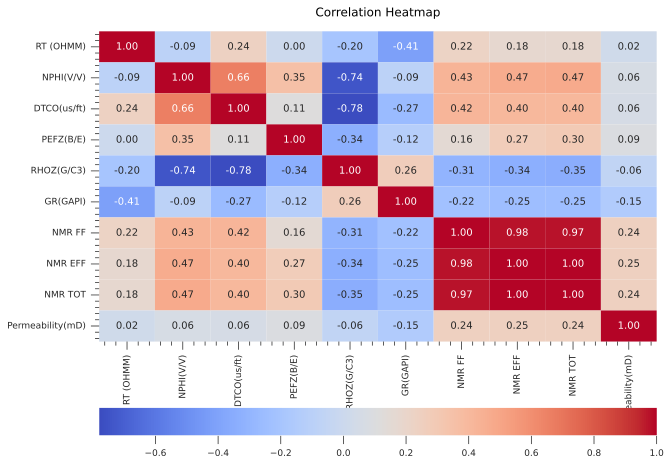

In [51]:
df_F = df_F[df_F['k'] > 0]   # Filter out rows with 'k' values less than or equal to zero

columns_of_interest = ["AT90", "NPHI", "DTCO", "PEFZ", "RHOZ", "GR", "NMRFF", "NMREFF", "NMRTOT", "k"]   # Select the columns of interest
df_F = df_F[columns_of_interest]

# Rename the columns with custom display names
df_F = df_F.rename(columns={
    "AT90": "RT (OHMM)",
    "NPHI": "NPHI(V/V)",
    "DTCO": "DTCO(us/ft)",
    "PEFZ": "PEFZ(B/E)",
    "RHOZ": "RHOZ(G/C3)",
    "GR": "GR(GAPI)",
    "NMRFF": "NMR FF",
    "NMREFF": "NMR EFF",
    "NMRTOT": "NMR TOT",
    "k": "Permeability(mD)"
})

# Calculate the correlation matrix
correlation_matrix = df_F.corr()

# Create a heatmap with horizontal property names on the vertical axis
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={"orientation": "horizontal"})

# Rotate the y-axis labels to be horizontal
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title("Correlation Heatmap")
plt.show()


================================================================================================================================================================================================================================================

In [52]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_2nd_part.csv'

combined_df.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_2nd_part.csv


In [53]:
# Count the number of values in the 'k' column falling within the 0-100 range
count_within_range = ((combined_df['k'] >= 0) & (combined_df['k'] <= 100)).sum()

# Calculate the percentage of values falling within the 0-100 range
percentage_within_range = (count_within_range / len(combined_df)) * 100
print(f"Percentage of 'k' values within 0-100 range: {percentage_within_range:.2f}%")

Percentage of 'k' values within 0-100 range: 60.07%


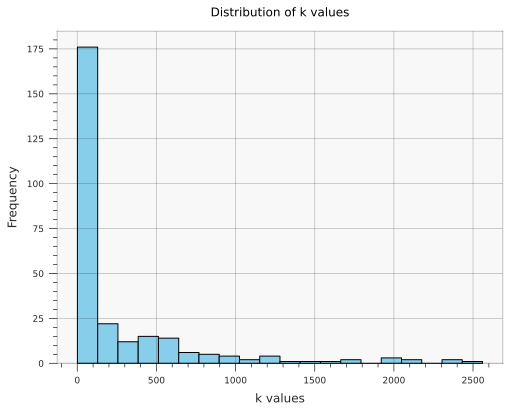

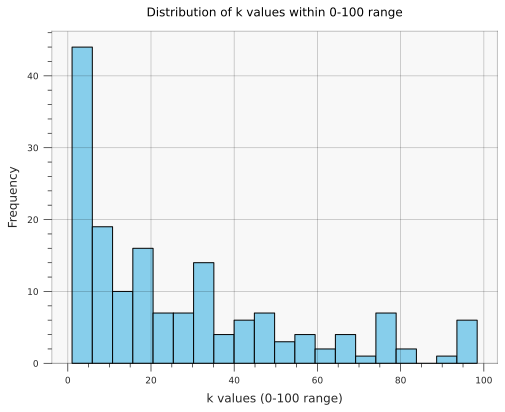

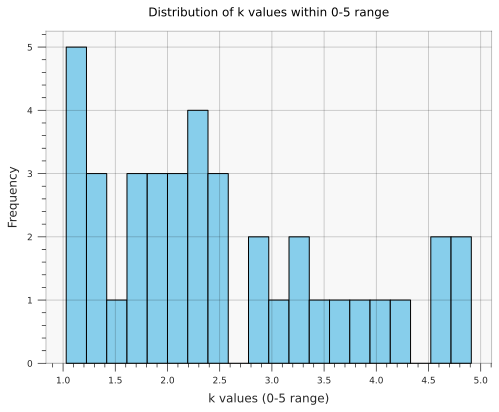

In [54]:
import matplotlib.pyplot as plt

# Plotting histogram for the 'k' column
plt.figure(figsize=(8, 6))
plt.hist(combined_df['k'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('k values')
plt.ylabel('Frequency')
plt.title('Distribution of k values')
plt.grid(True)
plt.show()

# Filter 'k' values within the 0-100 range
k_within_range = combined_df[(combined_df['k'] >= 0) & (combined_df['k'] <= 100)]['k']

# Plotting histogram for 'k' values within 0-100 range
plt.figure(figsize=(8, 6))
plt.hist(k_within_range, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('k values (0-100 range)')
plt.ylabel('Frequency')
plt.title('Distribution of k values within 0-100 range')
plt.grid(True)
plt.show()

# Filter 'k' values within the 0-5 range
k_within_subrange = combined_df[(combined_df['k'] >= 0) & (combined_df['k'] <= 5)]['k']

# Plotting histogram for 'k' values within 0-5 range
plt.figure(figsize=(8, 6))
plt.hist(k_within_subrange, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('k values (0-5 range)')
plt.ylabel('Frequency')
plt.title('Distribution of k values within 0-5 range')
plt.grid(True)
plt.show()


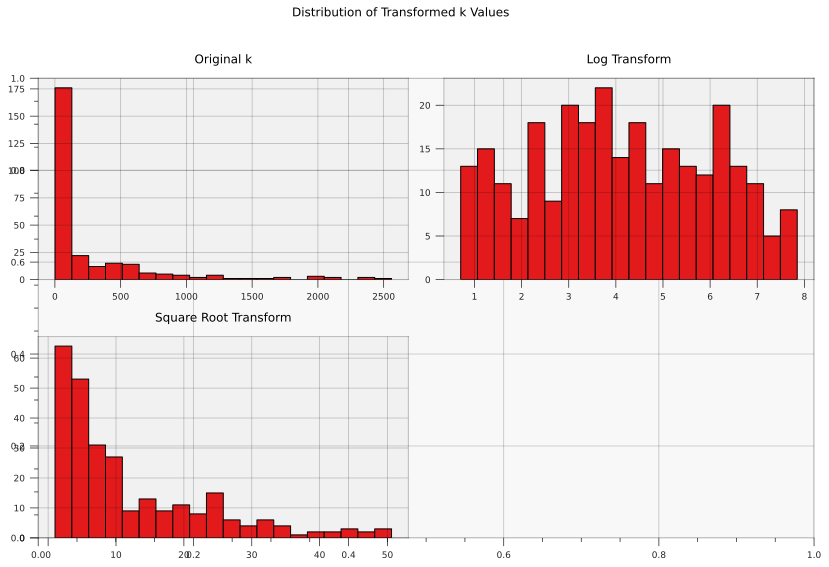

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#####

# Assuming 'combined_df' contains your dataset

# Selecting the 'k' column for transformation
k_values = combined_df['k']

# Logarithmic transformation
log_transformed_k = np.log1p(k_values)  # Applying log transformation, adding 1 to avoid log of zero or negative values

# Square root transformation
sqrt_transformed_k = np.sqrt(k_values)  # Applying square root transformation

# Creating a DataFrame to store the transformed values
transformed_df = pd.DataFrame({
    'Original k': k_values,
    'Log Transform': log_transformed_k,
    'Square Root Transform': sqrt_transformed_k
})

# Visualizing the transformed values
transformed_df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle('Distribution of Transformed k Values', y=1.02)
plt.tight_layout()
plt.show()


# Here's the corrected version to apply the shifted log transformation to the already log-transformed 'k' values

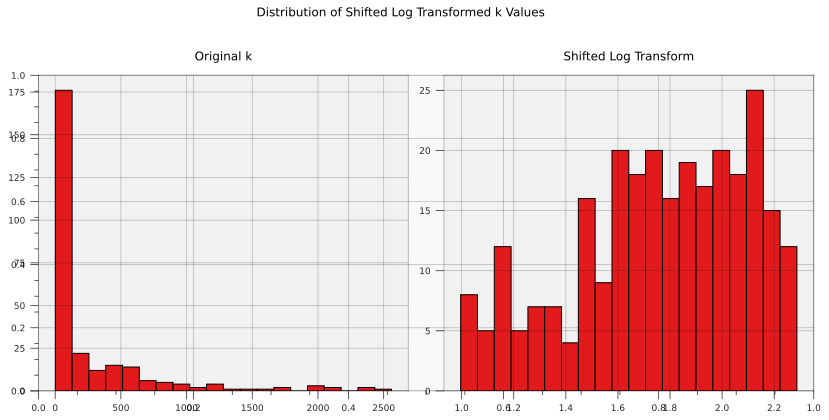

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'combined_df' contains your dataset

# Selecting the 'k' column for transformation
k_values = combined_df['k']

# Logarithmic transformation
log_transformed_k = np.log1p(k_values)  # Applying log transformation, adding 1 to avoid log of zero or negative values

# Shifting by a constant (1 here) before applying log transformation
shifted_log_transformed_k = np.log1p(log_transformed_k + 1)  # Adding 1 before log to shift the values

# Creating a DataFrame to store the transformed values
transformed_df = pd.DataFrame({
    'Original k': k_values,
    'Shifted Log Transform': shifted_log_transformed_k
})

# Visualizing the transformed values
transformed_df.hist(figsize=(12, 6), bins=20, edgecolor='black')
plt.suptitle('Distribution of Shifted Log Transformed k Values', y=1.02)
plt.tight_layout()
plt.show()


# Resampling

In [57]:
from sklearn.neighbors import KernelDensity
import numpy as np

# Assuming 'shifted_log_transformed_k' contains your shifted log-transformed 'k' values

# Fit a KDE model on your shifted log-transformed 'k' values
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')  # You may need to tune bandwidth
kde.fit(shifted_log_transformed_k.values.reshape(-1, 1))  # Reshape for sklearn compatibility

# Generate synthetic samples from the KDE model
num_synthetic_samples = 1000  # Set the number of synthetic samples you want to generate
synthetic_samples = kde.sample(n_samples=num_synthetic_samples)

# 'synthetic_samples' now contains new synthetic samples generated based on the KDE model


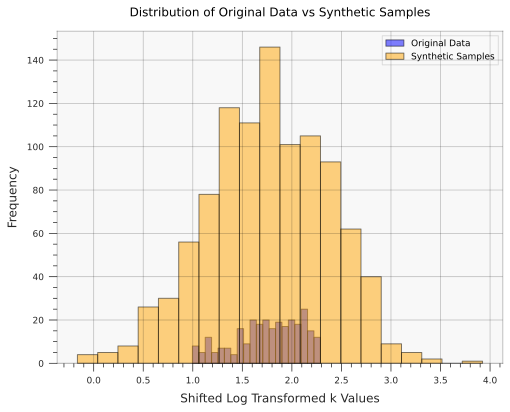

In [58]:
import matplotlib.pyplot as plt

# Plot histogram for the original shifted log-transformed 'k' values
plt.figure(figsize=(8, 6))
plt.hist(shifted_log_transformed_k, bins=20, color='blue', alpha=0.5, label='Original Data', edgecolor='black')

# Plot histogram for the generated synthetic samples
plt.hist(synthetic_samples, bins=20, color='orange', alpha=0.5, label='Synthetic Samples', edgecolor='black')

plt.xlabel('Shifted Log Transformed k Values')
plt.ylabel('Frequency')
plt.title('Distribution of Original Data vs Synthetic Samples')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
shifted_log_transformed_k

0      1.912602
1      1.977651
2      1.387675
3      1.359981
4      1.846451
         ...   
268    1.766103
269    1.472668
270    1.653808
271    1.568049
272    1.616404
Name: k, Length: 273, dtype: float64

Preprocessing the data to handle the skewed distribution of permeability values is crucial for developing an effective machine learning model. Here are some recommended approaches:

Transformation: Apply transformations to the permeability values to make the distribution more symmetrical. Common transformations include logarithmic transformation, square root transformation, and Box-Cox transformation. These transformations can effectively reduce the skewness and make the data more suitable for machine learning algorithms.

Resampling: Employ resampling techniques to balance the distribution of permeability values. Oversampling techniques like SMOTE (Synthetic Minority Oversampling Technique) can increase the number of minority class samples (low permeability values) to match the majority class (high permeability values). Conversely, undersampling techniques like Tomek links can remove some majority class samples to reduce the imbalance.

Normalization: Normalize the permeability values by scaling them to a range between 0 and 1. This can help prevent numerical instability in machine learning algorithms and improve their performance.

Use robust algorithms: Consider using machine learning algorithms that are less sensitive to outliers and skewed data distributions. Tree-based models like Random Forest and Gradient Boosting Trees are often robust to skewed distributions.

Evaluate different approaches: Experiment with different preprocessing techniques and evaluate their impact on the performance of your machine learning model. The optimal approach will depend on the specific characteristics of your data and the machine learning algorithm you choose.

====================================================================================

**The error message "Unknown label type: 'continuous'" indicates that the imbalanced-learn library is unable to handle continuous target variables. The SMOTE and TomekLinks resampling techniques are specifically designed for classification tasks, where the target variable is categorical. When dealing with continuous target variables, you'll need to use different resampling techniques or modify the existing ones to accommodate continuous values.**

**One approach is to discretize the continuous target variable into bins or categories before applying resampling techniques. This can be done using methods like binning or clustering to group similar values together. Once the target variable is discretized, you can apply resampling techniques like SMOTE or TomekLinks to balance the distribution of the categorical labels.**

**Alternatively, you can consider using resampling techniques that are specifically designed for continuous target variables. Some examples include:**

**Nearest Neighbors**: This involves creating new minority class samples by selecting existing minority class samples and their nearest neighbors from the majority class.

**Adaptive Synthetic (ADASYN)**: This method adaptively generates new minority class samples based on the density of the minority class in the feature space.

**Kernel Density Estimation (KDE)**: This technique utilizes kernel density estimation to create new minority class samples by sampling from a smoothed density distribution of the existing minority class samples.

Before applying any resampling technique, it's crucial to thoroughly understand the characteristics of your data and the specific requirements of your machine learning task. Carefully evaluate the impact of different resampling techniques on the performance of your model and choose the approach that best suits your data and problem.

